# Dooor Keep

In [1]:
import torch
import numpy as np
import open3d as o3d
import torch.nn.functional as F
import torch.nn as nn
from pytorch3d.transforms import rotation_6d_to_matrix, matrix_to_rotation_6d
import math
import os
import cv2
import re
import matplotlib.pylab as plt
import json
from pyhocon import ConfigFactory
import typing
import warnings
import torchvision.transforms as T
import tqdm

from models.fields import RenderingNetwork, SDFNetwork, SingleVarianceNetwork, NeRF, FeatureNetwork, FeatureField
from models.renderer import NeuSRenderer, MeanRenderer, select_vertices_and_update_triangles
from reconstruct.optimizer import Optimizer
from reconstruct.utils import color_table, set_view, get_configs

from models.features.clip_extract import CLIPArgs, extract_clip_features
from models.features.dino_extract import DINOArgs, extract_dino_features
from models.features.pca_colormap import apply_pca_colormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def split_underscore(input_str):
    # split the input string into the last part and the rest by underscore
    end = input_str.split('_')[-1]
    rest = '_'.join(input_str.split('_')[:-1])
    return rest, end


def load_checkpoint(case_name, checkpoint_fname):
    # read network config
    conf_path = './confs/wmask_ar.conf'
    f = open(conf_path)
    conf_text = f.read()
    conf_text = conf_text.replace('CASE_NAME', case_name) 
    f.close()
    conf = ConfigFactory.parse_string(conf_text)
    anneal_end = conf.get_float('train.anneal_end', default=0.0)

    # load feature field
    checkpoint = torch.load(os.path.join(checkpoint_fname), map_location='cuda')

    nerf_outside = NeRF(**conf['model.nerf']).to(device)
    sdf_network = SDFNetwork(**conf['model.sdf_network']).to(device)
    deviation_network = SingleVarianceNetwork(**conf['model.variance_network']).to(device)
    color_network = RenderingNetwork(**conf['model.rendering_network']).to(device)
    feature_network = FeatureField(**conf['model.feature_field']).to(device)
    feature_render = MeanRenderer()

    nerf_outside.load_state_dict(checkpoint['nerf'])
    sdf_network.load_state_dict(checkpoint['sdf_network_fine'])
    deviation_network.load_state_dict(checkpoint['variance_network_fine'])
    color_network.load_state_dict(checkpoint['color_network_fine'])
    feature_network.load_state_dict(checkpoint['feature_network'])
    renderer = NeuSRenderer(
        nerf_outside, sdf_network, deviation_network, color_network, feature_network, feature_render,**conf['model.neus_renderer']
    )

    print(f"loaded checkpoint from {checkpoint_fname}")
    return renderer, anneal_end


def extract_features_from_img(image_fnames: list, feat_type: str, visualize=False):

    """Extract features with support for caching.
    return features
    """
    feat_type_to_extract_fn = {
    "CLIP": extract_clip_features,
    "DINO": extract_dino_features,
    }

    if feat_type == "CLIP":
        raise NotImplementedError
    
    extract_fn = feat_type_to_extract_fn[feat_type]

    # Cache is invalid or doesn't exist, so extract features
    print(f"Extracting {feat_type} features for {len(image_fnames)} images...")
    features = extract_fn(image_fnames, device='cuda')
    
    if visualize == True:
        feature_pca = []
        for feature in features:
            feature_pca.append(apply_pca_colormap(feature).cpu().numpy())
        plt.figure()
        plt.suptitle("Visualize extracted PCA features")

        for i, (image_path, dino_pca_) in enumerate(zip(image_fnames, feature_pca)):
            plt.subplot(2, len(image_fnames), i + 1)
            plt.imshow(cv2.imread(image_path)[..., [2,1,0]])
            plt.title(os.path.basename(image_path))
            plt.axis("off")

            plt.subplot(2, len(image_fnames), len(image_fnames) + i + 1)
            plt.imshow(dino_pca_)
            plt.axis("off")

        plt.tight_layout()
        plt.savefig("demo_extract_features.png")
        print("Saved plot to demo_extract_features.png")
        plt.show()
    

    return features


def Rx_random():
    theta = np.random.uniform(-np.pi/3, np.pi/3)
    return torch.tensor([
        [1, 0, 0, 0],
        [0, np.cos(theta), -np.sin(theta), 0],
        [0, np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, 1]
    ], dtype=torch.float32)


def RT_opengl2opencv(RT):
    """convert between opengl and opencv coordinate convention"""
    R = RT[:3, :3]
    t = RT[:3, 3]

    R_bcam2cv = np.asarray([[1, 0, 0], [0, -1, 0], [0, 0, -1]], np.float32)

    R_world2cv = R_bcam2cv @ R
    t_world2cv = R_bcam2cv @ t

    RT = np.concatenate([R_world2cv,t_world2cv[:,None]],1)

    return RT


def unproj_map(width, height, f, c=None, device="cpu"):
    """
    Get camera unprojection map for given image size.
    [y,x] of output tensor will contain unit vector of camera ray of that pixel.
    :param width image width
    :param height image height
    :param f focal length, either a number or tensor [fx, fy]
    :param c principal point, optional, either None or tensor [fx, fy]
    if not specified uses center of image
    :return unproj map (height, width, 3)
    """
    if c is None:
        c = [width * 0.5, height * 0.5]
    else:
        c = c.squeeze()
    if isinstance(f, float):
        f = [f, f]
    elif len(f.shape) == 0:
        f = f[None].expand(2)
    elif len(f.shape) == 1:
        f = f.expand(2)
    Y, X = torch.meshgrid(
        torch.arange(height, dtype=torch.float32) - float(c[1]),
        torch.arange(width, dtype=torch.float32) - float(c[0]),
    )
    X = X.to(device=device) / float(f[0])
    Y = Y.to(device=device) / float(f[1])
    Z = torch.ones_like(X)
    unproj = torch.stack((X, -Y, -Z), dim=-1)
    unproj /= torch.norm(unproj, dim=-1).unsqueeze(-1)
    return unproj


def get_cos_anneal_ratio(iter_step):
    if anneal_end == 0.0:
        return 1.0
    else:
        return np.min([1.0, iter_step / anneal_end])


def rotation_matrix_to_r6d(rotation):
    """Convert a 3x3 rotation matrix to a 6D rotation vector.

    Args:
        rotation: 3x3 rotation matrix.

    Returns:
        6D rotation vector.
    """
    return_to_np, squeeze_dim = False, False
    if isinstance(rotation, np.ndarray):
        rotation = torch.from_numpy(rotation).float()
        return_to_np = True

    if len(rotation.shape) == 2:
        rotation = rotation.unsqueeze(0)
        squeeze_dim = True

    r6d = matrix_to_rotation_6d(rotation.transpose(-1, -2))

    if squeeze_dim:
        r6d = r6d.squeeze(0)

    if return_to_np:
        r6d = r6d.cpu().numpy()

    return r6d


def r6d_to_rotation_matrix(r6d):
    return_to_np, squeeze_dim = False, False
    if isinstance(r6d, np.ndarray):
        r6d = torch.from_numpy(r6d).float()
        return_to_np = True

    if len(r6d.shape) == 1:
        r6d = r6d.unsqueeze(0)
        squeeze_dim = True

    rotation = rotation_6d_to_matrix(r6d)
    rotation = rotation.transpose(-1, -2)

    if squeeze_dim:
        rotation = rotation.squeeze(0)

    if return_to_np:
        rotation = rotation.cpu().numpy()
    return rotation


def gen_rays(poses, width, height, focal, z_near, z_far, c=None, ndc=False):
    """
    Generate camera rays
    :return (B, H, width, 8)
    ndc: Normalized Device Coordinates
    """
    num_images = poses.shape[0]
    device = poses.device
    cam_unproj_map = (
        unproj_map(width, height, focal.squeeze(), c=c, device=device)
        .unsqueeze(0)
        .repeat(num_images, 1, 1, 1)
    )
    cam_centers = poses[:, None, None, :3, 3].expand(-1, height, width, -1)
    cam_raydir = torch.matmul(
        poses[:, None, None, :3, :3], cam_unproj_map.unsqueeze(-1)
    )[:, :, :, :, 0]

    if ndc:
        if not (z_near == 0 and z_far == 1):
            warnings.warn(
                "dataset z near and z_far not compatible with NDC, setting them to 0, 1 NOW"
            )
        z_near, z_far = 0.0, 1.0
        cam_centers, cam_raydir = ndc_rays(
            width, height, focal, 1.0, cam_centers, cam_raydir
        )

    cam_nears = (
        torch.tensor(z_near, device=device)
        .view(1, 1, 1, 1)
        .expand(num_images, height, width, -1)
    )
    cam_fars = (
        torch.tensor(z_far, device=device)
        .view(1, 1, 1, 1)
        .expand(num_images, height, width, -1)
    )
    return torch.cat(
        (cam_centers, cam_raydir, cam_nears, cam_fars), dim=-1
    )  # (B, H, W, 8)


# (poses, width, height, focal, z_near, z_far, c=None, ndc=False):
def gen_rays_from_a_view(poses, width, height, resolution_level=1):
    """
    poses: (B, 3, 4)    
    Generate rays at world space from one camera.
    """
    tx = torch.linspace(0, width, width)
    ty = torch.linspace(0, height, height)
    pixels_x, pixels_y = torch.meshgrid(tx, ty)
    pixels_x = pixels_x.reshape(-1).float()
    pixels_y = pixels_y.reshape(-1).float()

    q = torch.stack([(pixels_x/width-0.5)*2, (pixels_y/height-0.5)*2, torch.zeros_like(pixels_y)], dim=-1) # W, H, 3
    v = torch.stack([torch.zeros_like(pixels_y), torch.zeros_like(pixels_y), torch.ones_like(pixels_y)], dim=-1) # W, H, 3

    # orthogonal projection
    rays_v = v / torch.linalg.norm(v, ord=2, dim=-1, keepdim=True)  # W x H, 3 
    # print(rays_v.shape)
    # if len(poses.shape) == 3:
    #     poses = poses.unsqueeze(0)
    rays_v = torch.matmul(poses[:, :3, :3].cuda(), rays_v[:, :, None].cuda()).squeeze()   # batch_size, 3
    # print(rays_v.shape, poses[:, :3, :3].shape, rays_v[:, :, None].shape) # 
    
    rays_o = torch.matmul(poses[:,:3, :3].cuda(), q[:, :, None].cuda()).squeeze()   # batch_size, 3
    rays_o = poses[:, :3, 3].expand(rays_v.shape).cuda() + rays_o   # batch_size, 3
    rays = torch.cat([rays_o, rays_v], dim=-1)    # batch_size, 6
    return rays


def gen_rays_from_a_view2(poses, width, height, resolution_level=1):
    """
    poses: (B, 3, 4)    
    Generate rays at world space from one camera.
    """
    tx = torch.linspace(0, width, width)
    ty = torch.linspace(0, height, height)
    pixels_x, pixels_y = torch.meshgrid(tx, ty)
    pixels_x = pixels_x.reshape(-1).float()
    pixels_y = pixels_y.reshape(-1).float()

    q = torch.stack([(pixels_x/width-0.5)*2, (pixels_y/height-0.5)*2, torch.zeros_like(pixels_y)], dim=-1) # WxH, 3
    v = torch.stack([torch.zeros_like(pixels_y), torch.zeros_like(pixels_y), torch.ones_like(pixels_y)], dim=-1) # WxH, 3

    # orthogonal projection
    rays_v = v / torch.linalg.norm(v, ord=2, dim=-1, keepdim=True)  # WxH, 3 
    # print(rays_v.shape)
    if len(poses.shape) == 2: # (3,4) to (1,3,4)
        poses = poses.unsqueeze(0)
    rays_v = torch.matmul(poses[:, :3, :3].cuda(), rays_v[None, :, :].transpose(1,2).cuda())
    rays_v = rays_v.transpose(1,2) # B, WxH, 3
    
    rays_o = torch.matmul(poses[:,:3, :3].cuda(), q[None, :, :].transpose(1,2).cuda())  #B, 3, WxH 
    rays_o = rays_o.transpose(1,2) # B, WxH, 3
    rays_o = poses[:, :3, 3].unsqueeze(1).expand(rays_v.shape).cuda() + rays_o   # batch_size, 3
    rays = torch.cat([rays_o, rays_v], dim=-1)    # batch_size, 6
    return rays

def inv_RT(RT):
    RT_h = np.concatenate([RT, np.array([[0,0,0,1]])], axis=0)
    RT_inv = np.linalg.inv(RT_h)

    return RT_inv[:3, :]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# load the feature network
obj_name = 'owl'
ckpt_path = './exp/neus/'+ obj_name +'/checkpoints/ckpt_005000.pth'
print(ckpt_path)
renderer, anneal_end = load_checkpoint(obj_name, ckpt_path)


# extract DINO features
# target_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/outputs/cropsize-192-cfg1.0/owl/rgb/rgb_000_front_right.png'
# input_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/outputs/cropsize-192-cfg1.0/owl/rgb/rgb_000_front_left.png'

target_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/NeuS/outputs/rendered_img_4.png' # rendered from pose 4
input_img_fname = '/home/stud/zanr/code/tmp/Wonder3D/outputs/cropsize-192-cfg1.0/owl/rgb/rgb_000_front_left.png' # rendered use pose 3

target_img = cv2.imread(target_img_fname, -1) # BGR to RGB
input_img = cv2.imread(input_img_fname, -1)

# target_img_features = extract_features_from_img([target_img_fname], "DINO", visualize=True) 

# normalize image -> between 0 and 1
target_img = target_img / 255.0
input_img = input_img / 255.0


# visualization
# test_img = target_img_flatten.reshape(256,256,3)
# fig, axs = plt.subplots(1, 2)  # Fix: use plt.subplots instead of plt.subplot
# axs[0].imshow(target_img)
# axs[1].imshow(target_img_normalized)
# plt.show()
# print(target_img.mean())
# print(target_img_normalized.mean())  

./exp/neus/owl/checkpoints/ckpt_005000.pth
loaded checkpoint from ./exp/neus/owl/checkpoints/ckpt_005000.pth


## Training

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#
if type(target_img) != torch.Tensor:
    target_img = torch.from_numpy(target_img).float().to(device)
    input_img = torch.from_numpy(input_img).float().to(device)
in_sz = 128

target_img = target_img.permute(2, 0, 1) # HWC to CHW
input_img = input_img.permute(2, 0, 1) # HWC to CHW
target_img = T.Resize(in_sz)(target_img)
input_img = T.Resize(in_sz)(input_img)

print(target_img.shape)
target_img = target_img.permute(1, 2, 0) 
input_img = input_img.permute(1, 2, 0) # CHW to HWC

target_img_flatten =torch.reshape(target_img, [-1, 3])  # normalized

input_pose = torch.eye(4)
# input_pose[:3,:3] = Rx_random()[:3,:3]  
# input_pose[2, -1] = 1.8 # z translation -> input pose is not binded with input rgb image

# front left
# pose_fpath = '/home/stud/zanr/code/tmp/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_front_left_RT.txt' # pose 03
# pose_fpath = '/home/stud/zanr/code/tmp/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_front_right_RT.txt' # pose 04
pose_fpath = '/home/stud/zanr/code/tmp/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_front_RT.txt' # pose 05

pose_tmp = np.loadtxt(pose_fpath)
input_pose = torch.from_numpy(inv_RT(RT_opengl2opencv(pose_tmp)))
input_pose_r6d = rotation_matrix_to_r6d(input_pose[:3,:3])
input_pose_t = input_pose[:3,3]



# cam_pose = torch.clone(input_pose.detach()).unsqueeze(0) # batch_sz, 3, 4
cam_r6d = torch.clone(input_pose_r6d.detach()).unsqueeze(0)
cam_r6d.requires_grad = True

# print("Input pose:")
# print(f"{input_pose}")
print("Init pose:")
print(f"{cam_r6d[0]}")

# Create optimizer. 
lrate = 1e-2 # TODO chang to args
optimizer = torch.optim.Adam(params=[cam_r6d], lr=lrate)
n_steps = 100 + 1


# z_near, z_far = args.z_near, args.z_far
# focal = torch.tensor(args.focal, dtyfpe=torch.float32, device=device)
W, H = target_img.shape[1], target_img.shape[0]
z_near, z_far = 0.2, 2.4 # line 308 in dataset_mvdiff.py
focal = torch.tensor(W/2, dtype=torch.float32, device=device)


# Loss.
mse_loss = torch.nn.MSELoss()

# Sampling.
n_rays = 1024
sampling = 'center'

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []

for i_step in range(2):

    # r6d to rotation matrix
    cam_pose = torch.eye(4)
    cam_pose[:3,:3] = r6d_to_rotation_matrix(cam_r6d)
    cam_pose[:3,3] = input_pose_t
    cam_pose = torch.unsqueeze(cam_pose,0)
    print(cam_pose.shape)



torch.Size([3, 128, 128])
Init pose:
tensor([ 1.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  1.3436e-07,
        -1.0000e+00], dtype=torch.float64, grad_fn=<SelectBackward0>)
torch.Size([1, 4, 4])
torch.Size([1, 4, 4])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#
if type(target_img) != torch.Tensor:
    target_img = torch.from_numpy(target_img).float().to(device)
    input_img = torch.from_numpy(input_img).float().to(device)
in_sz = 128

target_img = target_img.permute(2, 0, 1) # HWC to CHW
input_img = input_img.permute(2, 0, 1) # HWC to CHW
target_img = T.Resize(in_sz)(target_img)
input_img = T.Resize(in_sz)(input_img)

print(target_img.shape)
target_img = target_img.permute(1, 2, 0) 
input_img = input_img.permute(1, 2, 0) # CHW to HWC

target_img_flatten =torch.reshape(target_img, [-1, 3])  # normalized

input_pose = torch.eye(4)
# input_pose[:3,:3] = Rx_random()[:3,:3]  
# input_pose[2, -1] = 1.8 # z translation -> input pose is not binded with input rgb image

# front left
# pose_fpath = '/home/stud/zanr/code/tmp/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_front_left_RT.txt' # pose 03
# pose_fpath = '/home/stud/zanr/code/tmp/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_front_right_RT.txt' # pose 04
pose_fpath = '/home/stud/zanr/code/tmp/Wonder3D/instant-nsr-pl/datasets/fixed_poses/000_front_RT.txt' # pose 05

pose_tmp = np.loadtxt(pose_fpath)
input_pose = torch.from_numpy(inv_RT(RT_opengl2opencv(pose_tmp)))
input_pose_r6d = rotation_matrix_to_r6d(input_pose[:3,:3])
input_pose_t = input_pose[:3,3]



# cam_pose = torch.clone(input_pose.detach()).unsqueeze(0) # batch_sz, 3, 4
cam_r6d = torch.clone(input_pose_r6d.detach()).unsqueeze(0)
cam_r6d.requires_grad = True

# print("Input pose:")
# print(f"{input_pose}")
print("Init pose:")
print(f"{cam_r6d[0]}")

# Create optimizer. 
lrate = 5e-2 # TODO chang to args
optimizer = torch.optim.Adam(params=[cam_r6d], lr=lrate)
n_steps = 100 + 1


# z_near, z_far = args.z_near, args.z_far
# focal = torch.tensor(args.focal, dtyfpe=torch.float32, device=device)
W, H = target_img.shape[1], target_img.shape[0]
z_near, z_far = 0.2, 2.4 # line 308 in dataset_mvdiff.py
focal = torch.tensor(W/2, dtype=torch.float32, device=device)


# Loss.
mse_loss = torch.nn.MSELoss()

# Sampling.
n_rays = 512
sampling = 'center'

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []

for i_step in range(n_steps):

    # r6d to rotation matrix
    cam_pose = torch.eye(4)
    cam_pose[:3,:3] = r6d_to_rotation_matrix(cam_r6d)
    cam_pose[:3,3] = input_pose_t
    cam_pose = torch.unsqueeze(cam_pose,0)


    # generate rays
    # render_rays = gen_rays(cam_pose, W, H, focal, z_near, z_far)
    render_rays = gen_rays_from_a_view(cam_pose, W, H)
    # render_rays = prepare_rays_a_view(target_img)
    render_rays_flatten = render_rays.view(-1, render_rays.shape[-1])
    assert render_rays_flatten.shape[0] == H*W
    # Sample rays.
    if sampling == 'random':
        idxs_sampled = torch.randint(0, H*W, (n_rays,))
    elif sampling == 'center':
        # take the area between 0.25-0.75 W and H
        frac = 0.5
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        # sample n_rays in this area for computing error
        idxs_masked = torch.where(mask>0)[0]
        idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
    elif sampling == 'patch':
        frac = 0.25
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        idxs_sampled = torch.where(mask>0)[0]

    # sample some rays
    render_rays_sampled = render_rays_flatten[idxs_sampled].to(device=device)

    # render rgb/ features
    render_out = renderer.render(
                                render_rays_sampled[:, 0:3], 
                                render_rays_sampled[:, 3:6], 
                                z_near, 
                                z_far, 
                                cos_anneal_ratio=get_cos_anneal_ratio(i_step), 
                                background_rgb=None
                                ) # TODO check get_cos_anneal_ratio(input)

    rgb = render_out['color_fine']
    # feature = render_out['feature']
    
    rgb_loss = mse_loss(rgb, target_img_flatten[idxs_sampled])

    optimizer.zero_grad()
    rgb_loss.backward()

    if i_step % 10 == 0:        
        predicted_poses.append(torch.clone(cam_pose[0]).detach().numpy())
        fine_patches.append(torch.clone(rgb).detach().cpu().numpy())
        gt_patches.append(torch.clone(target_img_flatten[idxs_sampled]).detach().cpu().numpy())

        # pose_pred = predicted_poses[-1].copy()
        # pose_pred[2, -1] -= 2.
        # pose_pred = input_pose @ pose_pred
        # error_R, error_t = compute_pose_error(pose_pred, pose_target)
        # print(f"Step {i_step}, loss: {rgb_loss}, error R: {error_R}, error t: {error_t}")
        print(f"Step {i_step}, loss: {rgb_loss}")
        
    optimizer.step()



torch.Size([3, 128, 128])
Init pose:
tensor([ 1.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  1.3436e-07,
        -1.0000e+00], dtype=torch.float64, grad_fn=<SelectBackward0>)
Step 0, loss: 0.037985630333423615
Step 10, loss: 0.024837549775838852
Step 20, loss: 0.022842053323984146
Step 30, loss: 0.021583247929811478
Step 40, loss: 0.022658061236143112
Step 50, loss: 0.026063522323966026
Step 60, loss: 0.023034915328025818
Step 70, loss: 0.021379923447966576
Step 80, loss: 0.022721661254763603
Step 90, loss: 0.023443881422281265
Step 100, loss: 0.0221384447067976


In [10]:
# save the predicted poses
predicted_poses_save = np.stack(predicted_poses, axis=0)
np.save('predicted_poses.npy', predicted_poses_save)

## Render Results

In [11]:
def create_image(patch):
    image = np.zeros((128, 128, 3))
    image[48:80, 48:80, :] = patch
    image = (image * 255.0).astype(np.uint8)
    return image

config = {
        'input': '.',
        'output':'./outputs',
        }

# Rendering.
overlay_frames = []
n_poses = len(predicted_poses)
render_poses = torch.from_numpy(np.array(predicted_poses)).float()
print("render_poses", render_poses.shape)

# render_rays = gen_rays(render_poses, W, H, focal, z_near, z_far)
# print(f'shape of rendered rays from inerf {render_rays.shape}')


# render single view from a predicted pose
for i in range(n_poses):
    render_rays = gen_rays_from_a_view(render_poses[i,None,:,:], W, H)
    render_rays = render_rays.to(device='cuda')

    with torch.no_grad():
        print(f"Rendering {H * W} rays for pose {i}")
        all_rgb_fine = []
        for rays in tqdm.tqdm(torch.split(render_rays.view(-1, render_rays.shape[-1]), 100, dim=0)):
            render_out = renderer.render(
                rays[..., 0:3], 
                rays[..., 3:6], 
                z_near, 
                z_far, 
                cos_anneal_ratio=get_cos_anneal_ratio(0), 
                background_rgb=None
            )

            rgb = render_out['color_fine']
            all_rgb_fine.append(rgb)
        
        rgb_fine = torch.cat(all_rgb_fine)
        frame = (rgb_fine.view(H, W, 3).cpu().numpy() * 255).astype(np.uint8)
        overlay_frames.append(frame)

render_poses torch.Size([11, 4, 4])
Rendering 16384 rays for pose 0


100%|██████████| 164/164 [00:02<00:00, 61.74it/s]


Rendering 16384 rays for pose 1


100%|██████████| 164/164 [00:02<00:00, 61.71it/s]


Rendering 16384 rays for pose 2


100%|██████████| 164/164 [00:02<00:00, 61.62it/s]


Rendering 16384 rays for pose 3


100%|██████████| 164/164 [00:02<00:00, 61.82it/s]


Rendering 16384 rays for pose 4


100%|██████████| 164/164 [00:02<00:00, 61.59it/s]


Rendering 16384 rays for pose 5


100%|██████████| 164/164 [00:02<00:00, 61.61it/s]


Rendering 16384 rays for pose 6


100%|██████████| 164/164 [00:02<00:00, 61.38it/s]


Rendering 16384 rays for pose 7


100%|██████████| 164/164 [00:02<00:00, 61.44it/s]


Rendering 16384 rays for pose 8


100%|██████████| 164/164 [00:02<00:00, 61.56it/s]


Rendering 16384 rays for pose 9


100%|██████████| 164/164 [00:02<00:00, 61.15it/s]


Rendering 16384 rays for pose 10


100%|██████████| 164/164 [00:02<00:00, 61.54it/s]


In [12]:
print(f'initial camera pose\n {predicted_poses[0]}')
print(f'optimized results\n {predicted_poses[-1]} ')

predicted_poses[-1][:3,:3] @ predicted_poses[-1][:3,:3].T

initial camera pose
 [[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.3435884e-07  1.0000000e+00 -1.3000000e+00]
 [-0.0000000e+00 -1.0000000e+00  1.3435884e-07  8.3696037e-15]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
optimized results
 [[ 9.1883147e-01  3.9361563e-01 -2.8556218e-02  0.0000000e+00]
 [ 3.1404540e-02 -7.9609780e-04  9.9950641e-01 -1.3000000e+00]
 [ 3.9339864e-01 -9.1927475e-01 -1.3092798e-02  8.3696037e-15]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]] 


array([[ 1.0000000e+00,  3.1556657e-10,  3.2410146e-08],
       [ 3.1556657e-10,  9.9999994e-01, -2.4632463e-11],
       [ 3.2410146e-08, -2.4632463e-11,  1.0000000e+00]], dtype=float32)

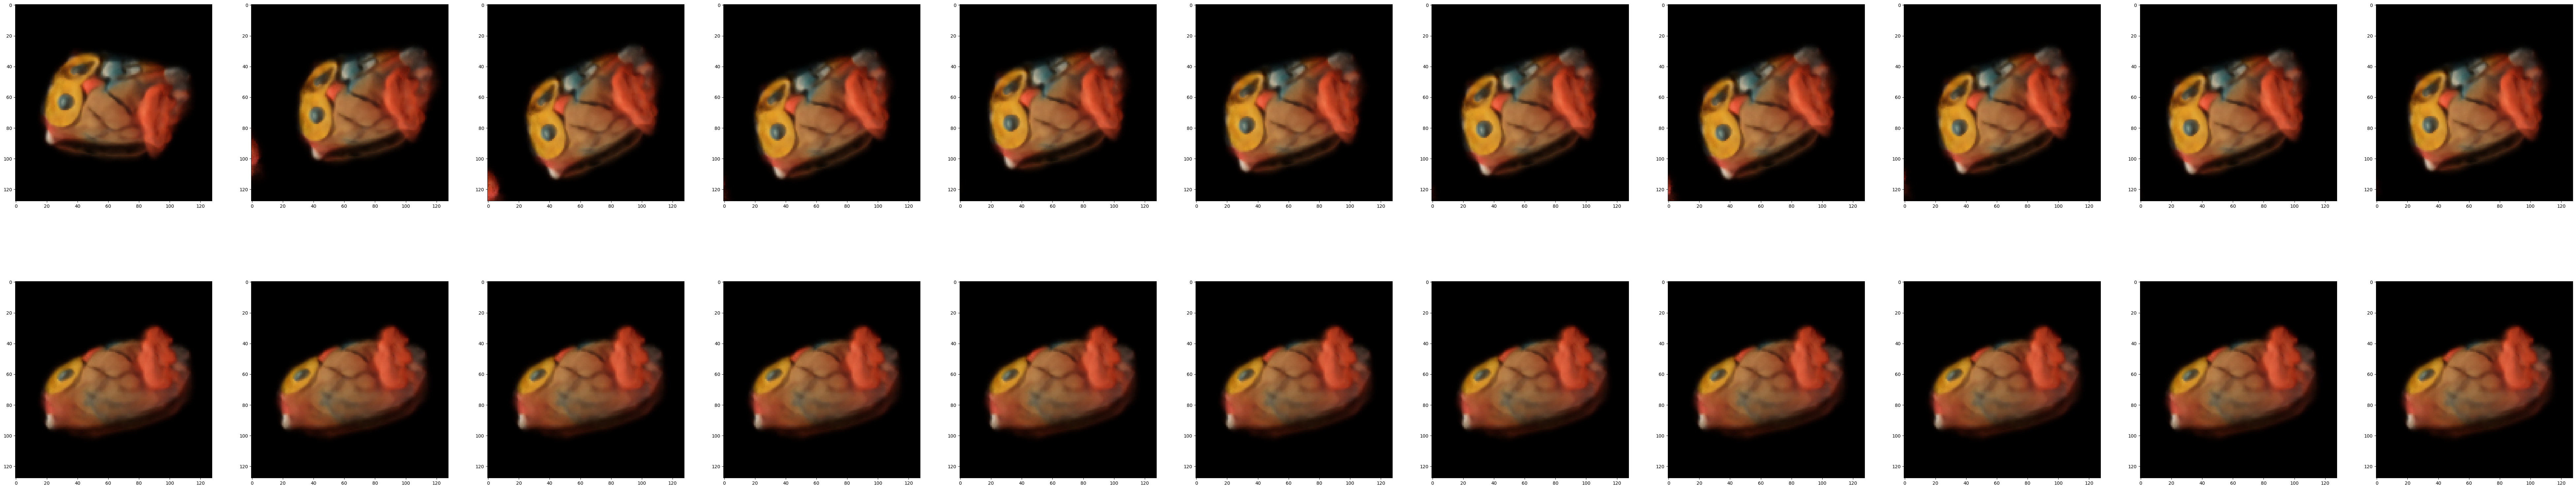

In [13]:
# draw results
target_img_np = (target_img * 255).cpu().numpy().astype(np.uint8)
fig, axs = plt.subplots(2, len(overlay_frames))
fig.set_size_inches(100, 20)
for i in range(len(fine_patches)):
    axs[0, i].imshow(overlay_frames[i][...,[2,1,0]])
    axs[1, i].imshow(target_img_np[...,[2,1,0]])

plt.show()

# Render Image using NERF

In [5]:
### temp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#
if type(target_img) != torch.Tensor:
    target_img = torch.from_numpy(target_img).float().to(device)
    input_img = torch.from_numpy(input_img).float().to(device)
in_sz = 128

target_img = target_img.permute(2, 0, 1) # HWC to CHW
input_img = input_img.permute(2, 0, 1) # HWC to CHW
target_img = T.Resize(in_sz)(target_img)
input_img = T.Resize(in_sz)(input_img)

print(target_img.shape)
target_img = target_img.permute(1, 2, 0) 
input_img = input_img.permute(1, 2, 0) # CHW to HWC

target_img_flatten =torch.reshape(target_img, [-1, 3]) # normalized


TypeError: expected np.ndarray (got NoneType)

In [25]:
cam_pose_dir = "../instant-nsr-pl/datasets/fixed_poses/"

predicted_poses = [] 
for poses_fpath in os.listdir(cam_pose_dir):
    pose_tmp = np.loadtxt(os.path.join(cam_pose_dir, poses_fpath))
    predicted_poses.append(inv_RT(RT_opengl2opencv(pose_tmp)))
print(f"Loaded {len(predicted_poses)} poses from {cam_pose_dir}")

# H, W = target_img.shape[1], target_img.shape[0]
H, W= 128, 128  
z_near, z_far = 0.2, 2.4 # line 308 in dataset_mvdiff.py
focal = torch.tensor(W/2, dtype=torch.float32, device=device)

# target_img = torch.from_numpy(target_img).float().to(device)
# target_img_flatten =torch.reshape(target_img, [-1, 3]) # normalized

Loaded 9 poses from ../instant-nsr-pl/datasets/fixed_poses/


In [28]:
def create_image(patch):
    image = np.zeros((128, 128, 3))
    image[48:80, 48:80, :] = patch
    image = (image * 255.0).astype(np.uint8)
    return image

config = {
        'input': '.',
        'output':'./outputs',
        }

# Rendering.
overlay_frames = []
n_poses = len(predicted_poses)

render_poses = torch.from_numpy(np.array(predicted_poses)).float()
print("render_poses", render_poses.shape)

# render_rays = gen_rays(render_poses, W, H, focal, z_near, z_far)
# print(f'shape of rendered rays from inerf {render_rays.shape}')
render_rays = gen_rays_from_a_view2(render_poses, W, H)
print(f'shape of rendered rays from NEUS {render_rays.shape}')
render_rays = render_rays.to(device='cuda')
with torch.no_grad():
    print("Rendering", n_poses * H * W, "rays")
    all_rgb_fine = []
    for rays in tqdm.tqdm(torch.split(render_rays.view(-1, render_rays.shape[-1]), 100, dim=0)):
        render_out = renderer.render(
                                    rays[..., 0:3], 
                                    rays[..., 3:6], 
                                    z_near, 
                                    z_far, 
                                    cos_anneal_ratio=get_cos_anneal_ratio(0), 
                                    background_rgb=None
                                    ) # TODO check get_cos_anneal_ratio(input)

        rgb = render_out['color_fine']
        all_rgb_fine.append(rgb)
    rgb_fine = torch.cat(all_rgb_fine)
    frames = (rgb_fine.view(n_poses, H, W, 3).cpu().numpy() * 255).astype(
        np.uint8
    )
# target_image = (target_img_flatten.cpu().numpy().reshape([H, W, 3]) * 255.0).astype(np.uint8)
# target_images = np.stack([np.array(target_image)]*n_poses, 0)


# im_name = os.path.basename(os.path.splitext(config['input'])[0])

# frames_dir_name = os.path.join(config['output'], im_name + "_frames")
# os.makedirs(frames_dir_name, exist_ok=True)

# for i in range(n_poses):
#     if sampling == 'patch':
#         pred_patch_path = os.path.join(config['output'], f'./pred_patch_{i}.png')
#         pred_image = create_image(fine_patches[i])

#         gt_patch_path = os.path.join(config['output'], f'./gt_patch_{i}.png')
#         gt_image = create_image(gt_patches[i])
#         overlay_frame = (pred_image*0.5).astype(np.uint8) + (gt_image*0.5).astype(np.uint8)
#     else:
#         overlay_frame = (frames[i]*0.5).astype(np.uint8) + (target_images[i]*0.5).astype(np.uint8)
#     overlay_frames.append(overlay_frame)

render_poses torch.Size([9, 3, 4])
shape of rendered rays from NEUS torch.Size([9, 16384, 6])
Rendering 147456 rays


  0%|          | 5/1475 [00:00<00:30, 48.81it/s]

100%|██████████| 1475/1475 [00:23<00:00, 62.34it/s]


In [33]:
os.makedirs(config['output'], exist_ok=True)
for ii in range(frames.shape[0]):
    rendered_img_path = os.path.join(config['output'], f'rendered_img_{ii}.png')
    cv2.imwrite(rendered_img_path, frames[ii])

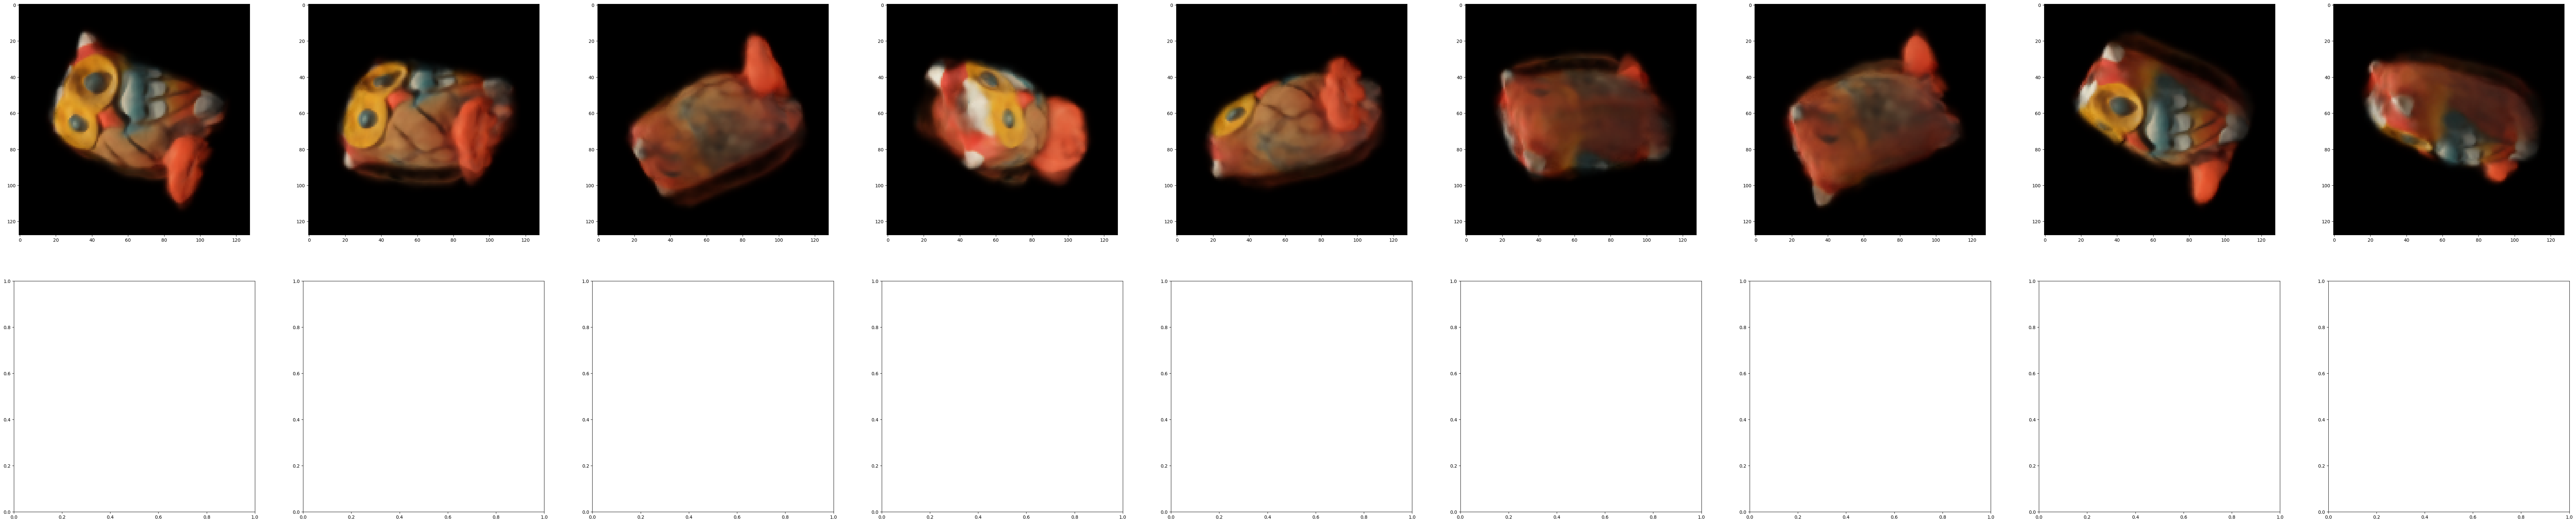

In [32]:
fig, axs = plt.subplots(2, n_poses)
fig.set_size_inches(100, 20)
for i in range(n_poses):
    axs[0, i].imshow(frames[i][...,[2,1,0]])
    # axs[1, i].imshow(target_img_np[...,[2,1,0]])


In [27]:
img = target_img_flatten[idxs_sampled].detach().cpu().numpy()